<div class="alert alert-info">
Laura Flores

</div>

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

import shapely.wkt
import shapely.geometry
from shapely import wkt
import matplotlib.dates as mdates
import collections
collections.Callable = collections.abc.Callable
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import warnings
warnings.filterwarnings('ignore')

In [2]:
import ee
# ee.Authenticate()

ee.Initialize()
print(ee.__version__)

import geemap

0.1.306


### Functions 

In [3]:
##Function to processing the data
# from gee_defs_short import *


In [4]:
from smooth_SG import *
# from S1_functions import *
from Gamma import *
from gee_functions import *

## shapefiles

### Change this fields

In [5]:
ID=8

if ID==2:
    ds = '2019-09-01' #start
    de = '2020-09-01' #end

if ID==3:
    ds = '2018-09-01' #start
    de = '2019-09-01' #end

if ID==4:
    ds = '2018-09-01' #start
    de = '2019-09-01' #end
    
if ID==5:
    ds = '2018-09-01' #start
    de = '2019-09-01' #end
    
if ID==8:
    ds = '2018-09-01' #start
    de = '2019-09-01' #end
    

In [6]:
cm=2/2.54
ll=11
l=10

largo=25
ancho=4

-------------------------------------------
## Crops shapefiles

> El shapefile field_outlines contiene la informacion de aquellos sitios con datos detallados de cultivo. Esta informacion es para calibrar las series de tiempo. 
Ademas esta informacion esta en coordinadas geograficas 4326. Asi es como debe cargarde. Averiguar como se hace para trabajar en metricas sin que se genere un error

In [7]:
label_fp='C:/Users/Usuario/Documents/codigos/Thesis/Thesis/info_vectorial/Management/field_outlines/field_outlines.shp'
# now load the shapefile using geopandas and check it's projection
shapefile = gpd.read_file(label_fp)

# print the head
print(shapefile.head(10))

print('\nthere are {} labels'.format(len(shapefile)))

# shapefile = shapefile.to_crs({'init': 'epsg:25832'})
print('\nprojection is: {}'.format(shapefile.crs))

   field id  field size    ID  \
0         1        2.58     d   
1         2       65.97     c   
2         3       14.90     a   
3         4       11.69     e   
4         6        3.81  None   
5         7        8.34  None   
6         8       56.03     b   
7         9       60.26  None   
8         5       13.48     f   

                                            geometry  
0  POLYGON ((12.93462 50.56671, 12.93530 50.56689...  
1  POLYGON ((13.09766 51.33932, 13.09883 51.33933...  
2  POLYGON ((11.74763 53.06296, 11.75287 53.06308...  
3  POLYGON ((10.83685 49.47271, 10.83782 49.47295...  
4  POLYGON ((11.67589 50.17714, 11.67630 50.17699...  
5  POLYGON ((11.81317 50.35535, 11.81358 50.35530...  
6  POLYGON ((13.91466 52.77635, 13.91523 52.77651...  
7  POLYGON ((13.91132 52.76778, 13.91159 52.76782...  
8  POLYGON ((11.99882 49.08490, 11.99907 49.08465...  

there are 9 labels

projection is: epsg:4326


En la siguiente linea elijo que poligonos seran usados

In [8]:
test2=shapefile.loc[shapefile['field id']==ID]
test2

,field id,field size,ID,geometry
6,8,56.03,b,"POLYGON ((13.91466 52.77635, 13.91523 52.77651..."



and this shape looks like:


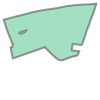

In [9]:
geoms_test2df = pd.DataFrame(test2['geometry'])
# (geoms_test2.info())

# this generates a list of shapely geometries
geoms_test2 = test2.geometry.values 
# to show you what this looks like let's grab a random polygon in the shapefile
geometry_test2 = geoms_test2[0] 
print('\nand this shape looks like:')
geometry_test2

In [10]:
list_wkt = test2.geometry.apply(lambda x: wkt.dumps(x))

list_polygons =  [shapely.wkt.loads(poly) for poly in list_wkt]

list_multipolygons= shapely.geometry.MultiPolygon(list_polygons) 

# list_multipolygons.centroid.x

In [11]:
cenxp2, cenyp2 = list_multipolygons.centroid.x, list_multipolygons.centroid.y
aoi_geep2 = gee_geometry_from_shapely(list_multipolygons)

Centroid = ee.Geometry.Point([(list_multipolygons.centroid.x), list_multipolygons.centroid.y])
clipper = Centroid.buffer(3000) #This is in METERS

print(cenxp2, cenyp2)

13.921543984241325 52.77476289434535


In [12]:
# stop

## Sentinel 1

In [13]:
polygon=aoi_geep2
data_asc = fix_S1(ds, de, polygon, orbit=None,  direction='Ascending') #gamma=True,
data_desc = fix_S1(ds, de, polygon, orbit=None,  direction='Descending')#gamma=True,

In [14]:
# data_asc.getInfo()

In [15]:
images_s = data_asc.toList(data_asc.size())
num_images = len(images_s.getInfo())
print(num_images)

120


In [16]:
# stop

In [17]:
# # // Functions to convert from/to dB
def toNatural(img):
    return ee.Image(10.0).pow(img.select('..').divide(10.0)).copyProperties(img, ['system:time_start'])

Aqui paso todos los datos de Decibeles a Numeros naturales

In [18]:
data_asc = data_asc.map(toNatural)
data_desc =data_desc.map(toNatural)

In [19]:
clipped = data_asc.map(lambda image: image.clip(clipper))
clipped2 = data_asc.map(lambda image: image.clip(aoi_geep2))

In [20]:
Map = geemap.Map(center=[cenyp2, cenxp2], zoom=12)
Map.addLayer(clipped)
Map.addLayer(clipped2)
Map.addLayer(aoi_geep2)
# Map

### Time Serie

In [21]:
#### different bands for orbits type:

S1_VV_a= data_asc.select('VV')
S1_VH_a= data_asc.select('VH')

S1_VV_d= data_desc.select('VV')
S1_VH_d= data_desc.select('VH')

In [22]:
mean_std_VV_a = export_to_pandas(S1_VV_a, clipper=aoi_geep2, aggregation_scale=10, med='mean')
mean_std_VH_a = export_to_pandas(S1_VH_a, clipper=aoi_geep2, aggregation_scale=10, med='mean')

# mean_std_VV_d = export_to_pandas(S1_VV_d, clipper=aoi_geep2, aggregation_scale=10, med='mean')
# mean_std_VH_d = export_to_pandas(S1_VH_d, clipper=aoi_geep2, aggregation_scale=10, med='mean')


In [23]:
mean_VV=mean_std_VV_a[0]#np.concatenate([mean_std_VV_a[0],mean_std_VV_d[0]])
mean_VH=mean_std_VH_a[0]#np.concatenate([mean_std_VH_a[0],mean_std_VH_d[0]])

date_mean=mean_std_VV_a[0].index#np.concatenate([mean_std_VV_a[0].index,mean_std_VV_d[0].index])

In [24]:
date_mean= date_mean[~(np.isnan(mean_VH))]
mean_VV= mean_VV[~(np.isnan(mean_VV))]
mean_VH= mean_VH[~(np.isnan(mean_VH))]

date_mean= date_mean[~(np.isnan(mean_VH))]

##### RVI

Formula: RVI = 4*VH/(VV+VH)


In [25]:
mean_ratio = mean_VH/mean_VV

RVI=(4*mean_VH)/(mean_VV+mean_VH)

In [26]:
df=pd.DataFrame({'vv mean':mean_VV,
                 'vh mean':mean_VH,
                 'vh/vv mean':mean_ratio,
                 'RVI':RVI,
                 'Date':date_mean})

df=df.sort_values(by=['Date'])

In [27]:
df=df.reset_index()
# df

In [28]:
df['Date'] = pd.to_datetime(df['Date'])
# del df_50th['index']

queda por incluir el ratio

In [29]:
import datetime
df['Days']=df.Date.dt.dayofyear

In [30]:
# df.head(10)

In [31]:
n=3
some_position=np.where([df.index.values % n == 0])
some_date=(df['Date'].loc[df.index.values % n == 0]).values
some_days=df['Days'].loc[df.index.values % n == 0].values

In [32]:
some_days

array([249, 267, 285, 303, 321, 339, 357,  10,  28,  46,  64,  82, 100,
       118, 136, 154, 172, 190, 208, 226], dtype=int64)

In [33]:
list_string = list(map(str, np.array(df['Days']).tolist()) )
list_some_days=list(map(str,some_days.tolist()))

In [34]:
wind=5
order=1

df['SG_vv']=savitzky_golay(df['vv mean'].values, wind,order, deriv=0, rate=1)
df['SG_vh']=savitzky_golay(df['vh mean'].values,wind,order, deriv=0, rate=1)
df['SG_vh/vv']=savitzky_golay(df['vh/vv mean'].values, wind,order, deriv=0, rate=1)

In [35]:
###Database Farms
ffarms='C:/Users/Usuario/Documents/codigos/Thesis/Thesis/info_vectorial/Management/Database_FarmsLaura_ww.csv'
dfarm = pd.read_csv(ffarms, index_col='field_ID')
# dfarm

In [36]:
dfarm['sowing_date'] = pd.to_datetime(dfarm['sowing_date'],dayfirst=True, format ="%d/%m/%Y")
dfarm['harvest_date'] = pd.to_datetime(dfarm['harvest_date'],dayfirst=True, format ="%d/%m/%Y")

In [37]:
so=dfarm['sowing_date'].loc[dfarm.index==ID].values
ha=dfarm['harvest_date'].loc[dfarm.index==ID].values
T=str(dfarm['tillage'].loc[dfarm.index==ID].values[0])

## Validation

1. DWD air temperature
2. DWD precipitation

Nota: el error que yo estaba teniendo era porque en la temperatura y precipitacion tengo informacion de todas las estaciones, asi que tendre para la misma fecha datos de diferente estaciones. 

Para calibrar necesito solo estaciones cercanas al lugar de estudio. 

En el codigo DWD debo generar un archivo con la ubicacion en coodrinadas log lat de todas las estaciones que estoy usando

temperatura:

Metadaten_Geraete_Lufttemperatur_00164
En este archivo se almacenan la ubicacion de las estaciones, y debo considerar la ubicacion de la estacion que tomo los valores mas tarde.

Ya tengo listo los csv con la ubicacion de las estaciones, seleccionando la mas reciente. 

Sigueinte paso es calcular la distancia con euclides, y asi obtener las estaciones mas cercanas al sitio de estudio

In [38]:
###Station Locations
ftloc='F:/Documents/info_vectorial/data/DWD/air_temp_stationloc.csv'
df_temp_geo = pd.read_csv(ftloc ,sep=',')
df_temp_geo['Date']=pd.to_datetime(df_temp_geo['Date'],yearfirst=True, format='%Y%m%d',errors='coerce')
del df_temp_geo['Unnamed: 0']

In [39]:
# df_temp_geo

In [40]:
fploc='F:/Documents/info_vectorial/data/DWD/precip_stationLoc.csv'
df_prec_geo = pd.read_csv(fploc ,sep=',')
df_prec_geo['Date']=pd.to_datetime(df_prec_geo['Date'],yearfirst=True, format='%Y%m%d',errors='coerce')
del df_prec_geo['Unnamed: 0']

In [41]:
# df_prec_geo

Ahora calcular la distancia y ver cual es la estacion correcta:

In [42]:
import math

def splitFloat(x):
    """Split each element of x on space and convert into float-sublists"""
    return list(map(float,x.split()))

def dist(p1, p2):
    # you could remove the sqrt for computation benefits, its a symetric func
    # that does not change the relative ordering of distances
    # p1 es lista de puntos
    # p2 punto a comparar
    return math.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)


In [43]:
pt=df_temp_geo[['Lon','Lat']].values.tolist()
pp=df_prec_geo[['Lon','Lat']].values.tolist()

s=[cenxp2, cenyp2]

In [44]:
# p = ["9.5 7.5", "10.2 19.1", "9.7 10.2", "2.5 3.6", "5.5 6.5", "7.8 9.8"]

# s = splitFloat("2.2 4.6")       # your start point
# p = [splitFloat(x) for x in p]  # your list of points



# sort by distance between each individual x and s
pt.sort(key = lambda x:dist(x,s))
pp.sort(key = lambda x:dist(x,s))


dt = [ (dist(x,s),x) for x in pt]  # create tuples with distance for funsies

dp = [ (dist(x,s),x) for x in pp]  # create tuples with distance for funsies

print(pt[0])
print(dt[0])

print(pp[0])
print(dp[0])

[13.8427, 52.7461]
(0.08389240348982123, [13.8427, 52.7461])
[13.8427, 52.7461]
(0.08389240348982123, [13.8427, 52.7461])


In [45]:
posiciont=df_temp_geo['station'].loc[df_temp_geo['Lon']==pt[0][0]]
posiciont.values

array([7389], dtype=int64)

In [46]:
posicionp=df_prec_geo['station'].loc[df_prec_geo['Lon']==pp[0][0]]
posicionp.values

array([7389], dtype=int64)

Datos de temperatura y precipitacion 

In [47]:
###air temperature
ftemp='C:/Users/Usuario/Documents/codigos/Thesis/Thesis/validation/air_temp_daily_Brand.csv'
dtemp = pd.read_csv(ftemp ,sep=',')
dtemp['dates']=pd.to_datetime(dtemp['dates'])
# dtemp

In [48]:
dtemp_station=dtemp.loc[(dtemp['STATIONS_ID'].values==posiciont.values)&(dtemp['dates']>=ds)&(dtemp['dates']<=de)]
# dtemp_station

In [49]:
### Precipitation
fprec='C:/Users/Usuario/Documents/codigos/Thesis/Thesis/validation/precip_daily_Brand.csv'
dprec = pd.read_csv(fprec ,sep=',')
dprec['dates']=pd.to_datetime(dprec['dates'])
# dprec

In [50]:
dprec_station=dprec.loc[(dprec['STATIONS_ID'].values==posicionp.values)&(dprec['dates']>=ds)&(dprec['dates']<=de)]
dprec_station['R1']=dprec_station['  R1']
dprec_station=dprec_station.loc[dprec_station['R1']>=0]
# dprec_station

### Phenology

lugar: C:\Users\Flores\Documents\PythonScripts\codigos\Thesis\validation
data: rWinter_Wheat_Phenology_Filtered_1951TO2019_N

DAY: day of the year

In [51]:
### Phenology
fph='C:/Users/Usuario/Documents/codigos/Thesis/Thesis/validation/Winter_Wheat_Phenology_Filtered_1951TO2019_N.txt'
dph = pd.read_csv(fph ,sep=';')
# dph['dates']=pd.to_datetime(dh['dates'])
# dph

In [52]:
# dph['Year'].max()

### Phenology filter for year first and then for the location

In [53]:
dph_young=dph.loc[dph['Year']>=int(ds.split('-')[0])]
# dph_young

In [54]:
pph=dph_young[['Longitude','Latitude']].values.tolist()

pph.sort(key = lambda x:dist(x,s))


distph = [ (dist(x,s),x) for x in pph]  # create tuples with distance for funsies


print(pph[0])
print(distph[0])

[14.1122, 52.9226]
(0.24125821468567013, [14.1122, 52.9226])


In [55]:
diff_location=[pph[0]]

for i in range(len(pph)-1):
    if pph[i]!=pph[i+1]:
        diff_location.append(pph[i+1])
               
 

In [56]:
print(len(pph))
print(diff_location[:3])  

7502
[[14.1122, 52.9226], [14.1667, 52.8], [13.9908, 53.0316]]


In [57]:
posicion_phe=dph_young.loc[(dph_young['Longitude']==pph[0][0])&(dph_young['Latitude']==pph[0][1])]

list_location=diff_location[:3]

for i in range(len(list_location)):
    posicion_phe_n=dph_young.loc[(dph_young['Longitude']==list_location[i][0])&(dph_young['Latitude']==list_location[i][1])]
    posicion_phe=pd.concat([posicion_phe,posicion_phe_n])


# posicion_phe

In [58]:
fecha=[]
for d in range(len(posicion_phe)):
    origen=str(posicion_phe.iloc[d]['Year'])
    doy=posicion_phe.iloc[d]['DOY']
    fecha.append(pd.to_datetime(doy-1, unit='D', origin=origen))

posicion_phe['current']=fecha

posicion_phe=posicion_phe.loc[(posicion_phe['current']>=ds)&(posicion_phe['current']<=de)]
# posicion_phe

In [59]:
# posicion_phe.sort_values(by=['current'])
posicion_phe=posicion_phe.sort_values(by=['current']).drop_duplicates(subset=['Phase'])
# posicion_phe

In [60]:
file_phe='F:/Images_S1andCopernicus_Brandenburg/image_statisticMaps/wheat_PHE_%(ID)d.csv'% {'ID': ID}
posicion_phe.to_csv(file_phe, encoding='utf-8', index=False)

The plot below corresponde to the exactly year for the phenological stages

## Phenology data from Copernicus Lands Service Data

In [61]:
fcop_phe='C:/Users/Usuario/Documents/codigos/Thesis/Thesis/csv/copernicus_phenology_crop{}.csv'.format(ID)
df_cop_phe = pd.read_csv(fcop_phe ,sep=',')
df_cop_phe

,Unnamed: 0,name,median,doy,year,date,type
0,0,VPP_2018_S2_T33UVU-010m_V101_s1_EOSD4326.tif,18215.0,215.0,2018,2018-08-03,EOS
1,1,VPP_2018_S2_T33UVU-010m_V101_s1_MAXD4326.tif,18165.0,165.0,2018,2018-06-14,MAX
2,2,VPP_2018_S2_T33UVU-010m_V101_s1_SOSD4326.tif,18133.0,133.0,2018,2018-05-13,SOS
3,3,VPP_2019_S2_T33UVU-010m_V101_s1_EOSD4326.tif,19189.0,189.0,2019,2019-07-08,EOS
4,4,VPP_2019_S2_T33UVU-010m_V101_s1_MAXD4326.tif,19131.0,131.0,2019,2019-05-11,MAX
5,5,VPP_2019_S2_T33UVU-010m_V101_s1_SOSD4326.tif,19058.0,58.0,2019,2019-02-27,SOS
6,6,VPP_2020_S2_T33UVU-010m_V101_s1_EOSD4326.tif,20154.0,154.0,2020,2020-06-02,EOS
7,7,VPP_2020_S2_T33UVU-010m_V101_s1_MAXD4326.tif,20112.0,112.0,2020,2020-04-21,MAX
8,8,VPP_2020_S2_T33UVU-010m_V101_s1_SOSD4326.tif,20048.0,48.0,2020,2020-02-17,SOS


In [62]:
df_cop_phe['type2']=df_cop_phe['type']

In [63]:
for z in range(len(df_cop_phe)):
    if df_cop_phe['type'].iloc[z]=='SOS':
        df_cop_phe['type2'].iloc[z]='SHO'
    else:
        df_cop_phe['type2'].iloc[z]=df_cop_phe['type'].iloc[z]

In [64]:
df_cop_phe=df_cop_phe.loc[(df_cop_phe['date']>=ds)&(df_cop_phe['date']<=de)]
df_cop_phe

,Unnamed: 0,name,median,doy,year,date,type,type2
3,3,VPP_2019_S2_T33UVU-010m_V101_s1_EOSD4326.tif,19189.0,189.0,2019,2019-07-08,EOS,EOS
4,4,VPP_2019_S2_T33UVU-010m_V101_s1_MAXD4326.tif,19131.0,131.0,2019,2019-05-11,MAX,MAX
5,5,VPP_2019_S2_T33UVU-010m_V101_s1_SOSD4326.tif,19058.0,58.0,2019,2019-02-27,SOS,SHO


In [65]:
file_cop_phe='F:/Images_S1andCopernicus_Brandenburg/image_statisticMaps/wheat_COP_PHE_%(ID)d.csv'% {'ID': ID}
df_cop_phe.to_csv(file_cop_phe, encoding='utf-8', index=False)

### Sentinel 2

In [66]:
S2 = ee.ImageCollection("COPERNICUS/S2_SR")\
        .filter(ee.Filter.date(ds, de))\
        .filterBounds(aoi_geep2)

In [67]:
def maskcloud1(image):
    QA60 = image.select(['QA60'])
    return image.updateMask(QA60.eq(0)) ###

def createTS(image):
    date = image.get('system:time_start')
    value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=ROI).get(var)
    std = image.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=ROI).get(var)
    ft = ee.Feature(None, {'date': ee.Date(date).format('Y/M/d'), var: value, 'STD': std})
    return ft

def TS_to_pandas(TS):
    dump = TS.getInfo()
    fts = dump['features']
    out_vals = np.empty((len(fts)))
    out_dates = []
    out_std = np.empty((len(fts)))
    
    for i, f in enumerate(fts):
        props = f['properties']
        date = props['date']
        val = props[var]
        std = props['STD']
        out_vals[i] = val
        out_std[i] = std
        out_dates.append(pd.Timestamp(date))
    
    ser = pd.Series(out_vals, index=out_dates)
    return ser, out_std

In [68]:
ROI=aoi_geep2
var='NDVI'
S2_mask=S2.map(maskS2clouds)
ndvi = S2_mask.map(NDVI_S2)
TS = ndvi.map(createTS)
ser, std = TS_to_pandas(TS)

In [69]:
# ser

In [70]:
NDVI_inter=ser.interpolate(method='linear', order=4)

windS2=7
orderS2=3

NDVI_SG=savitzky_golay(NDVI_inter.values, windS2,order, deriv=0, rate=1)




df_S2=pd.DataFrame({'NDVI_original':ser,
                    'NDVI_interp':NDVI_inter,
                    'NDVI_SG':NDVI_SG,
                    'Date':ser.index})

In [71]:
windRVI=3
orderRVI=1

RVI_SG=savitzky_golay(df['RVI'].values, windRVI,orderRVI, deriv=0, rate=1)

df_RVI=pd.DataFrame({'RVI_original': df['RVI'].values,
                    'RVI_SG':RVI_SG,
                    'Date':df['Date']})

In [72]:
dti_so = pd.date_range(so[0], periods=5, freq="D")
dti_ha = pd.date_range(ha[0], periods=5, freq="D")

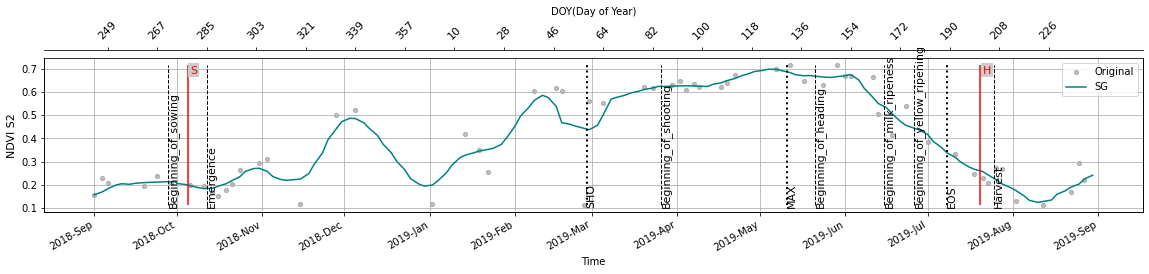

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(largo*cm,ancho*cm),constrained_layout=True)

plt.subplots_adjust(hspace=0.8)

variable='NDVI_original'###
variableSG='NDVI_SG'
nombresy='NDVI S2'
dfs=df_S2
# ll=9


dfs.plot.scatter(x='Date',y=variable,ax=ax,label='Original', alpha=0.5, 
                    legend=True, color='grey',marker='8')
dfs.plot(x='Date',y=variableSG,ax=ax, legend=True,color='teal',
           linewidth=1.5,label='SG')#:Win=%(window)d, Ord= %(order)d'% {'window': windS2, 'order': orderS2})
ax.set_ylabel(nombresy[i])
ax.grid()
ax.set_xlabel('Time', fontsize=10)
ax6 = plt.twiny(ax)
ax6.spines.top.set_position(("axes", 1.05)) 
ax6.set_xlim(ax.get_xlim())
ax6.tick_params('x', colors='k', pad=6)
ax6.set_xlabel("DOY(Day of Year)", fontsize =l)
ax6.set_xticks(some_date)
ax6.set_xticklabels(list_some_days,rotation=30, fontsize =l)
###--------------------------------------------------------------------------------------------------------
ax.vlines(x =so ,ymin = dfs[variable].min(), ymax = (dfs[variable].max()) ,colors = 'red',
          linestyles='solid', linewidth=1.5)
ax.text(x =dti_so[1] ,y = (dfs[variable].max())*0.95,s='S',rotation=0, c= 'red',fontsize=ll,
          bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

ax.vlines(x = ha ,ymin = dfs[variable].min(), ymax = (dfs[variable].max()) ,colors = 'red',
          linestyles='solid',linewidth=1.5)
ax.text(x =dti_ha[1] ,y = (dfs[variable].max())*0.95,s='H',rotation=0, c = 'red',fontsize=ll,
          bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

ax.set_ylabel(nombresy, fontsize=ll)
###----------------------------------------------------------------------------------------------------


for j in range(len(posicion_phe)):
    ax.vlines(x =np.array(posicion_phe['current'])[j] ,ymin = dfs[variable].min(), 
                 ymax = dfs[variable].max(), 
                 colors='k',linestyles='dashed',linewidth=1)
    ax.text(x=np.array(posicion_phe['current'])[j], y=dfs[variable].min(),
               s=np.array(posicion_phe['Phase'])[j],rotation=90,fontsize=ll, zorder=8)


for j in range(len(df_cop_phe)):
    ax.vlines(x =np.array(df_cop_phe['date'])[j] ,ymin = dfs[variable].min(), ymax = dfs[variable].max(), 
                 colors='black',linestyles='dotted',linewidth=2)
    ax.text(x=np.array(df_cop_phe['date'])[j], y=dfs[variable].min(),
               s=np.array(df_cop_phe['type2'])[j],rotation=90,fontsize=ll)#, 
               #bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))


dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
ax.xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45, fontweight='light', fontsize=ll) ;

    
plt.savefig("plot/plot_febrero2023/NDVI_wheat_%(ID)d.png"% {'ID': ID}, dpi=300,  bbox_inches="tight")

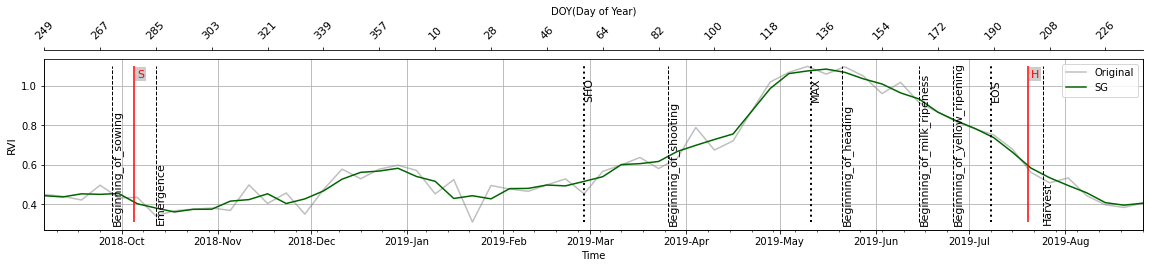

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(largo*cm,ancho*cm))

plt.subplots_adjust(hspace=0.8)

variable='RVI_original'###
variableSG='RVI_SG'
nombresy='RVI'
dfs=df_RVI
# ll=9

dfs.plot(x='Date',y=variable,ax=ax,label='Original', alpha=0.5,legend=True, color='grey')
dfs.plot(x='Date',y=variableSG,ax=ax, legend=True,color='darkgreen',
           linewidth=1.5,label='SG')#:Win=%(window)d, Ord= %(order)d'% {'window': windS2, 'order': orderS2})
ax.set_ylabel(nombresy)
ax.set_xlabel('Time', fontsize=10)
ax.grid()

ax6 = plt.twiny(ax)
ax6.spines.top.set_position(("axes", 1.05)) 
ax6.set_xlim(ax.get_xlim())
ax6.tick_params('x', colors='k', pad=6)
ax6.set_xlabel("DOY(Day of Year)", fontsize =l)
ax6.set_xticks(some_date)
ax6.set_xticklabels(list_some_days,rotation=30, fontsize =l)
###--------------------------------------------------------------------------------------------------------
ax.vlines(x =so ,ymin = dfs[variable].min(), ymax = (dfs[variable].max()) ,colors = 'red',
          linestyles='solid', linewidth=1.5)
ax.text(x =dti_so[1] ,y = (dfs[variable].max())*0.95,s='S',rotation=0, c= 'red',fontsize=ll,
          bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

ax.vlines(x = ha ,ymin = dfs[variable].min(), ymax = (dfs[variable].max()) ,colors = 'red',
          linestyles='solid',linewidth=1.5)
ax.text(x =dti_ha[1] ,y = (dfs[variable].max())*0.95,s='H',rotation=0, c = 'red',fontsize=ll,
          bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

ax.set_ylabel(nombresy, fontsize=ll)
###----------------------------------------------------------------------------------------------------


for j in range(len(posicion_phe)):
    ax.vlines(x =np.array(posicion_phe['current'])[j] ,ymin = dfs[variable].min(), 
                 ymax = dfs[variable].max(), 
                 colors='k',linestyles='dashed',linewidth=1)
    ax.text(x=np.array(posicion_phe['current'])[j], y=dfs[variable].min(),
               s=np.array(posicion_phe['Phase'])[j],rotation=90,fontsize=ll, zorder=8)


for j in range(len(df_cop_phe)):
    ax.vlines(x =np.array(df_cop_phe['date'])[j] ,ymin = dfs[variable].min(), ymax = dfs[variable].max(), 
                 colors='black',linestyles='dotted',linewidth=2)
    ax.text(x=np.array(df_cop_phe['date'])[j], y=(dfs[variable].max())*0.85,
               s=np.array(df_cop_phe['type2'])[j],rotation=90,fontsize=ll)#, 
               #bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))


        


     
        
dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
ax.xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45, fontweight='light', fontsize=ll) ;

    
plt.savefig("plot/plot_febrero2023/RVI_wheat_%(ID)d.png"% {'ID': ID}, dpi=300,  bbox_inches="tight")
# 

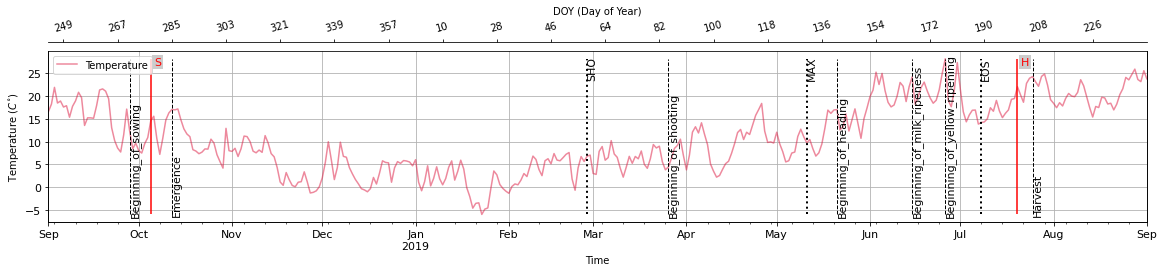

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(largo*cm,ancho*cm),constrained_layout=True)
# l=10
plt.subplots_adjust(hspace=0.4)
dtemp_station.plot(x='dates',y='TT_TU',ax=ax, label='Temperature', alpha=0.5, legend=True,c='crimson',fontsize=ll)

variable='TT_TU'
ax.grid()
ax.set_xlabel('Time', fontsize=l)
ax.set_ylabel('Temperature ($C^{\circ}$)', fontsize=l)


ax2 = plt.twiny(ax)
ax2.spines.top.set_position(("axes", 1.05)) 
ax2.set_xlim(ax.get_xlim())
ax2.tick_params('x', colors='k', pad=6)
ax2.set_xlabel("DOY (Day of Year)", fontsize =l)
ax2.set_xticks(some_date)
ax2.set_xticklabels(list_some_days,rotation=375, fontsize =l);

# ###--------------------------------------------------------------------------------------------------------
ax.vlines(x =so ,ymin = dtemp_station[variable].min(), ymax = (dtemp_station[variable].max()) ,colors = 'red',
          linestyles='solid', linewidth=1.5)
ax.text(x =dti_so[1] ,y = (dtemp_station[variable].max())*0.95,s='S',rotation=0, c= 'red',fontsize=ll,
          bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

ax.vlines(x = ha ,ymin = dtemp_station[variable].min(), ymax = (dtemp_station[variable].max()) ,colors = 'red',
          linestyles='solid',linewidth=1.5)
ax.text(x =dti_ha[1] ,y = (dtemp_station[variable].max())*0.95,s='H',rotation=0, c = 'red',fontsize=ll,
          bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))


###----------------------------------------------------------------------------------------------------


for j in range(len(posicion_phe)):
    ax.vlines(x =np.array(posicion_phe['current'])[j] ,ymin = dtemp_station[variable].min(), 
                 ymax = dtemp_station[variable].max(), 
                 colors='k',linestyles='dashed',linewidth=1)
    ax.text(x=np.array(posicion_phe['current'])[j], y=dtemp_station[variable].min(),
               s=np.array(posicion_phe['Phase'])[j],rotation=90,fontsize=ll, zorder=8)


for j in range(len(df_cop_phe)):
    ax.vlines(x =np.array(df_cop_phe['date'])[j] ,ymin = dtemp_station[variable].min(), ymax = dtemp_station[variable].max(), 
                 colors='black',linestyles='dotted',linewidth=2)
    ax.text(x=np.array(df_cop_phe['date'])[j], y=(dtemp_station[variable].max())*0.85,
               s=np.array(df_cop_phe['type2'])[j],rotation=90,fontsize=ll)#, 
               #bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))


plt.savefig("plot/plot_febrero2023/temp_poligono_%(ID)d_wheat.png"% {'ID': ID}, dpi=300,  bbox_inches="tight")

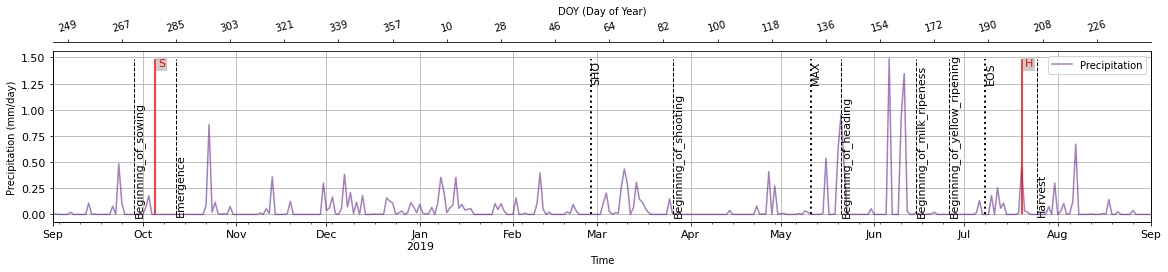

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(largo*cm,ancho*cm),constrained_layout=True)

plt.subplots_adjust(hspace=0.4)

dprec_station.plot(x='dates',y='R1',ax=ax, label='Precipitation', alpha=0.5, legend=True, c='indigo',fontsize=ll)

variable='R1'
ax.grid()
ax.set_xlabel('Time', fontsize=l)
ax.set_ylabel('Precipitation (mm/day)', fontsize=l)



ax2 = plt.twiny(ax)
ax2.spines.top.set_position(("axes", 1.05)) 
ax2.set_xlim(ax.get_xlim())
ax2.tick_params('x', colors='k', pad=6)
ax2.set_xlabel("DOY (Day of Year)", fontsize =l)
ax2.set_xticks(some_date)
ax2.set_xticklabels(list_some_days,rotation=375, fontsize =l);

# ###--------------------------------------------------------------------------------------------------------
ax.vlines(x =so ,ymin = dprec_station[variable].min(), ymax = (dprec_station[variable].max()) ,colors = 'red',
          linestyles='solid', linewidth=1.5)
ax.text(x =dti_so[1] ,y = (dprec_station[variable].max())*0.95,s='S',rotation=0, c= 'red',fontsize=ll,
          bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

ax.vlines(x = ha ,ymin = dprec_station[variable].min(), ymax = (dprec_station[variable].max()) ,colors = 'red',
          linestyles='solid',linewidth=1.5)
ax.text(x =dti_ha[1] ,y = (dprec_station[variable].max())*0.95,s='H',rotation=0, c = 'red',fontsize=ll,
          bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))


###----------------------------------------------------------------------------------------------------


for j in range(len(posicion_phe)):
    ax.vlines(x =np.array(posicion_phe['current'])[j] ,ymin = dprec_station[variable].min(), 
                 ymax = dprec_station[variable].max(), 
                 colors='k',linestyles='dashed',linewidth=1)
    ax.text(x=np.array(posicion_phe['current'])[j], y=dprec_station[variable].min(),
               s=np.array(posicion_phe['Phase'])[j],rotation=90,fontsize=ll, zorder=8)


for j in range(len(df_cop_phe)):
    ax.vlines(x =np.array(df_cop_phe['date'])[j] ,ymin = dprec_station[variable].min(), ymax = dprec_station[variable].max(), 
                 colors='black',linestyles='dotted',linewidth=2)
    ax.text(x=np.array(df_cop_phe['date'])[j], y=(dprec_station[variable].max())*0.85,
               s=np.array(df_cop_phe['type2'])[j],rotation=90,fontsize=ll)#, 
               #bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))


plt.savefig("plot/plot_febrero2023/precip_poligono_%(ID)d_wheat.png"% {'ID': ID}, dpi=300,  bbox_inches="tight")

### Inflections and slope

### inflection points

In [77]:
from complementary_fn import *

In [78]:
##### inflection points for SG function
n=4
df['peakP_minsg_vv']=(local_peak_potencial(df['SG_vv'].values,n))['mini']
df['peakP_maxsg_vv']=(local_peak_potencial(df['SG_vv'].values,n))['maxi']

df['peakP_minsg_vh']=(local_peak_potencial(df['SG_vh'].values,n))['mini']
df['peakP_maxsg_vh']=(local_peak_potencial(df['SG_vh'].values,n))['maxi']

df['peakP_minsg_vh/vv']=(local_peak_potencial(df['SG_vh/vv'].values,n))['mini']
df['peakP_maxsg_vh/vv']=(local_peak_potencial(df['SG_vh/vv'].values,n))['maxi']

### slope:

In [79]:
df2=df
variable=['vv','vh','vh/vv']
i=6
for v in variable:
    name=str('WinSize%(i)d_%(v)s'%{'i':i,'v':v})
    val=slope(df[('%(v)s mean'%{'v':v})].values,win_size=i)
    ss=pd.DataFrame(data={name:val})
    df2=pd.concat([df2,ss], axis=1)


for v in variable:
    name=str('SG_WinSize%(i)d_%(v)s'%{'i':i,'v':v})
    val=slope(df[('SG_%(v)s'%{'v': v})].values,win_size=i)
    ss=pd.DataFrame(data={name:val})
    df2=pd.concat([df2,ss], axis=1)

# df2

In [80]:
df2['year'] = df2.Date.dt.year
df2['month'] = df2.Date.dt.month 
# df2['mean_win6']=  df2.groupby(["year","month"])['WinSize6_vh/vv'].transform('mean')
# df2['mean_win6_week']=df2.groupby([pd.Grouper(key='Date', freq='SM')])['WinSize6_vh/vv'].transform('mean')
# df2

In [81]:
variable=['vv','vh','vh/vv']
i=6
for v in variable:
    name=str('MeanStepWeek_%(v)s'%{'v':v})
    n=str('SG_WinSize%(i)d_%(v)s'%{'i':i,'v':v})
    val=df2.groupby([pd.Grouper(key='Date', freq='SM')])[n].transform('mean')
    ss=pd.DataFrame(data={name:val})
    df2=pd.concat([df2,ss], axis=1)

for v in variable:
    name=str('MaxStepWeek_%(v)s'%{'v':v})
    n=str('SG_WinSize%(i)d_%(v)s'%{'i':i,'v':v})
    val=df2.groupby([pd.Grouper(key='Date', freq='SM')])[n].transform('max')
    ss=pd.DataFrame(data={name:val})
    df2=pd.concat([df2,ss], axis=1)


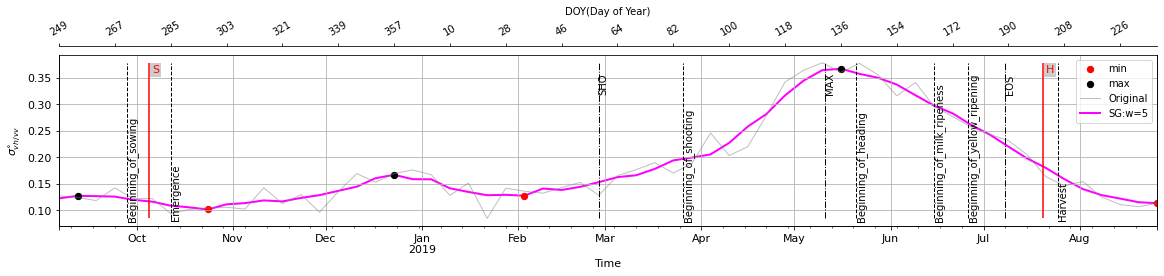

In [82]:
''' OFICIAL'''

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates

fig1, ax = plt.subplots(nrows=1, ncols=1,figsize=(largo*cm,ancho*cm),constrained_layout=True)


plt.subplots_adjust(hspace=0.5)

# fig1.suptitle('Backscatter Coefficient Ratios for polygon N°%(ID)d: %(T)s'%{'ID':ID, 'T':T}, fontsize=15)

# l=14
variable=['vh/vv']###vh/vv,vv,vh


for v in variable:
    
    ### max and min for SG
    yvalues5=str('peakP_minsg_%(v)s'%{'v': v})
    yvalues6=str('peakP_maxsg_%(v)s'%{'v': v})
    
    df.plot(x='Date',y=str(yvalues5),ax=ax, label='min', legend=True, c='r',s=40, kind='scatter',fontsize=ll).legend(loc='lower left',fontsize=l)
    
    df.plot(x='Date',y=str(yvalues6),ax=ax, label='max', legend=True, c='k',s=40, kind='scatter',fontsize=ll).legend(loc='lower left',fontsize=l)
    
####################################################################    
    yvalue1=str('%(v)s mean'%{'v': v})
    df.plot(x='Date',y=yvalue1,ax=ax, label='Original', alpha=0.5, legend=True, color='grey',linewidth=1,fontsize=ll)

    ###--------------------------------------------------------------------------------------------------------
    ax.vlines(x =so ,ymin = df[yvalue1].min(), ymax = (df[yvalue1].max()) ,colors = 'red',zorder=2,
              linestyles='solid', linewidth=1.5)
    ax.text(x =dti_so[1] ,y = (df[yvalue1].max())*0.95,s='S',rotation=0, c= 'red',fontsize=ll,zorder=2,
              bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

    ax.vlines(x = ha,ymin = df[yvalue1].min(), ymax = (df[yvalue1].max()) ,colors = 'red',zorder=2,
              linestyles='solid',linewidth=1.5)
    ax.text(x =dti_ha[1] ,y = (df[yvalue1].max())*0.95,s='H',rotation=0, c = 'red',fontsize=ll,zorder=2,
              bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

    ax.set_ylabel(yvalue1, fontsize=ll)
    ###----------------------------------------------------------------------------------------------------
    

    for j in range(len(posicion_phe)):
        ax.vlines(x =np.array(posicion_phe['current'])[j] ,ymin = df[yvalue1].min(), ymax = df[yvalue1].max(), 
                     colors='black',linestyles='dashed',linewidth=1,zorder=2)
        ax.text(x=np.array(posicion_phe['current'])[j], y=df[yvalue1].min(),
                   s=np.array(posicion_phe['Phase'])[j],rotation=90,fontsize=l,zorder=2)


    for j in range(len(df_cop_phe)):
        ax.vlines(x =np.array(df_cop_phe['date'])[j] ,ymin = df[yvalue1].min(), ymax = df[yvalue1].max(), 
                     colors='black',linestyles='dashdot',linewidth=1,zorder=2)
        ax.text(x=np.array(df_cop_phe['date'])[j], y=(df[yvalue1].max())*0.85,
                   s=np.array(df_cop_phe['type2'])[j],rotation=90,fontsize=l, zorder=2)

    dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
    ax.xaxis.set_major_formatter(dtFmt) 
    # show every 12th tick on x axes
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45, fontweight='light', fontsize=ll) 

    ### SG
    yvalue4='SG_%(v)s'%{'v': v}
    df.plot(x='Date',y=yvalue4,ax=ax, legend=True,color='magenta',linewidth=2,zorder=0,
             label='SG:w=%(window)d'% {'window': wind})
    ax.grid()
    ax.set_xlabel('Time', fontsize=ll)
    ax.set_ylabel('$\sigma_{%(v)s}^{\circ}$'%{'v': v}, fontsize=ll)

# lines = []
# labels = []

# Lines, Labels = fig1.axes[0].get_legend_handles_labels()
# # print(Label)
# lines.extend(Lines)
# labels.extend(Labels)    
    
# fig1.legend(lines, labels, loc='upper right', fontsize=12) 
# # fig1.legend(handles=[p2, p3],fontsize=12)


ax2 = plt.twiny(ax)
ax2.spines.top.set_position(("axes", 1.05)) 
ax2.set_xlim(ax.get_xlim())
ax2.tick_params('x', colors='black', pad=6)
ax2.set_xlabel("DOY(Day of Year)", fontsize =l)
ax2.set_xticks(some_date)
ax2.set_xticklabels(list_some_days,rotation=30, fontsize =l);

if variable[0]=="vh/vv":
    variable[0]='vhvv'
    

plt.savefig("plot/plot_febrero2023/BSResults_wheat_%(ID)d_%(v)s.png"% {'ID': ID,'v':variable[0]}, dpi=300,  bbox_inches="tight")


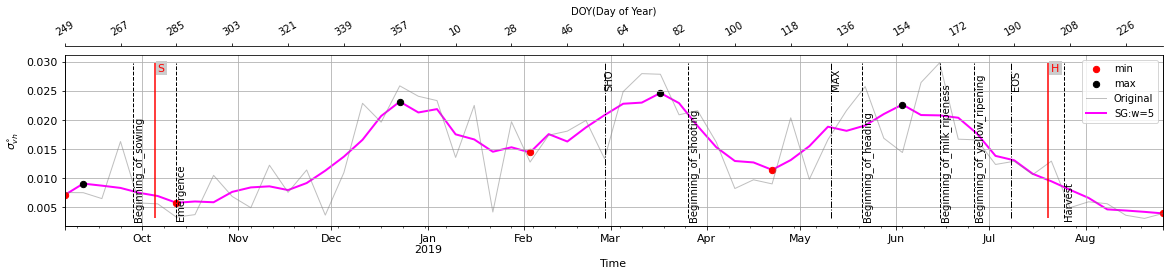

In [83]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates

fig1, ax = plt.subplots(nrows=1, ncols=1,figsize=(largo*cm,ancho*cm),constrained_layout=True)


plt.subplots_adjust(hspace=0.5)

# fig1.suptitle('Backscatter Coefficient Ratios for polygon N°%(ID)d: %(T)s'%{'ID':ID, 'T':T}, fontsize=15)

# l=14
variable=['vh']###vh/vv,vv,vh


for v in variable:
    
    ### max and min for SG
    yvalues5=str('peakP_minsg_%(v)s'%{'v': v})
    yvalues6=str('peakP_maxsg_%(v)s'%{'v': v})
    
    df.plot(x='Date',y=str(yvalues5),ax=ax, label='min', legend=True, c='r',s=40, kind='scatter',fontsize=ll).legend(loc='lower left',fontsize=l)
    
    df.plot(x='Date',y=str(yvalues6),ax=ax, label='max', legend=True, c='k',s=40, kind='scatter',fontsize=ll).legend(loc='lower left',fontsize=l)
    
####################################################################    
    yvalue1=str('%(v)s mean'%{'v': v})
    df.plot(x='Date',y=yvalue1,ax=ax, label='Original', alpha=0.5, legend=True, color='grey',linewidth=1,fontsize=ll)

    ###--------------------------------------------------------------------------------------------------------
    ax.vlines(x =so ,ymin = df[yvalue1].min(), ymax = (df[yvalue1].max()) ,colors = 'red',zorder=2,
              linestyles='solid', linewidth=1.5)
    ax.text(x =dti_so[1] ,y = (df[yvalue1].max())*0.95,s='S',rotation=0, c= 'red',fontsize=ll,zorder=2,
              bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

    ax.vlines(x = ha,ymin = df[yvalue1].min(), ymax = (df[yvalue1].max()) ,colors = 'red',zorder=2,
              linestyles='solid',linewidth=1.5)
    ax.text(x =dti_ha[1] ,y = (df[yvalue1].max())*0.95,s='H',rotation=0, c = 'red',fontsize=ll,zorder=2,
              bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

    ax.set_ylabel(yvalue1, fontsize=ll)
    ###----------------------------------------------------------------------------------------------------
    

    for j in range(len(posicion_phe)):
        ax.vlines(x =np.array(posicion_phe['current'])[j] ,ymin = df[yvalue1].min(), ymax = df[yvalue1].max(), 
                     colors='black',linestyles='dashed',linewidth=1,zorder=2)
        ax.text(x=np.array(posicion_phe['current'])[j], y=df[yvalue1].min(),
                   s=np.array(posicion_phe['Phase'])[j],rotation=90,fontsize=l,zorder=2)


    for j in range(len(df_cop_phe)):
        ax.vlines(x =np.array(df_cop_phe['date'])[j] ,ymin = df[yvalue1].min(), ymax = df[yvalue1].max(), 
                     colors='black',linestyles='dashdot',linewidth=1,zorder=2)
        ax.text(x=np.array(df_cop_phe['date'])[j], y=(df[yvalue1].max())*0.85,
                   s=np.array(df_cop_phe['type2'])[j],rotation=90,fontsize=l, zorder=2)

    dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
    ax.xaxis.set_major_formatter(dtFmt) 
    # show every 12th tick on x axes
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45, fontweight='light', fontsize=ll) 

    ### SG
    yvalue4='SG_%(v)s'%{'v': v}
    df.plot(x='Date',y=yvalue4,ax=ax, legend=True,color='magenta',linewidth=2,zorder=0,
             label='SG:w=%(window)d'% {'window': wind})
    ax.grid()
    ax.set_xlabel('Time', fontsize=ll)
    ax.set_ylabel('$\sigma_{%(v)s}^{\circ}$'%{'v': v}, fontsize=ll)

# lines = []
# labels = []

# Lines, Labels = fig1.axes[0].get_legend_handles_labels()
# # print(Label)
# lines.extend(Lines)
# labels.extend(Labels)    
    
# fig1.legend(lines, labels, loc='upper right', fontsize=12) 
# # fig1.legend(handles=[p2, p3],fontsize=12)


ax2 = plt.twiny(ax)
ax2.spines.top.set_position(("axes", 1.05)) 
ax2.set_xlim(ax.get_xlim())
ax2.tick_params('x', colors='black', pad=6)
ax2.set_xlabel("DOY(Day of Year)", fontsize =l)
ax2.set_xticks(some_date)
ax2.set_xticklabels(list_some_days,rotation=30, fontsize =l);

if variable[0]=="vh/vv":
    variable[0]='vhvv'
    

plt.savefig("plot/plot_febrero2023/BSResults_wheat_%(ID)d_%(v)s.png"% {'ID': ID,'v':variable[0]}, dpi=300,  bbox_inches="tight")


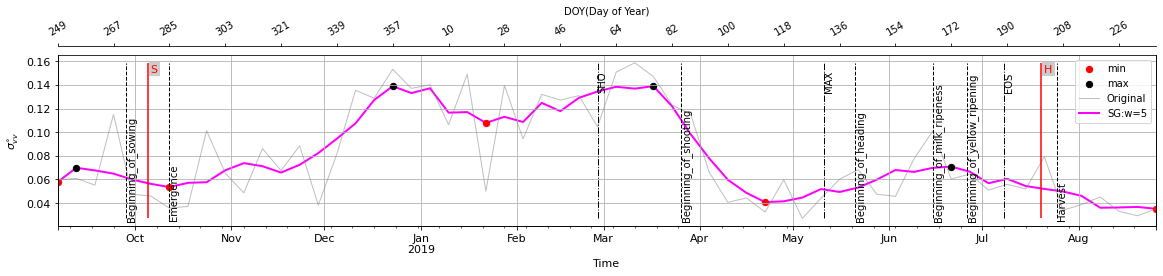

In [84]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates

fig1, ax = plt.subplots(nrows=1, ncols=1,figsize=(largo*cm,ancho*cm),constrained_layout=True)


plt.subplots_adjust(hspace=0.5)

# fig1.suptitle('Backscatter Coefficient Ratios for polygon N°%(ID)d: %(T)s'%{'ID':ID, 'T':T}, fontsize=15)

# l=14
variable=['vv']###vh/vv,vv,vh


for v in variable:
    
    ### max and min for SG
    yvalues5=str('peakP_minsg_%(v)s'%{'v': v})
    yvalues6=str('peakP_maxsg_%(v)s'%{'v': v})
    
    df.plot(x='Date',y=str(yvalues5),ax=ax, label='min', legend=True, c='r',s=40, kind='scatter',fontsize=ll).legend(loc='lower left',fontsize=l)
    
    df.plot(x='Date',y=str(yvalues6),ax=ax, label='max', legend=True, c='k',s=40, kind='scatter',fontsize=ll).legend(loc='lower left',fontsize=l)
    
####################################################################    
    yvalue1=str('%(v)s mean'%{'v': v})
    df.plot(x='Date',y=yvalue1,ax=ax, label='Original', alpha=0.5, legend=True, color='grey',linewidth=1,fontsize=ll)

    ###--------------------------------------------------------------------------------------------------------
    ax.vlines(x =so ,ymin = df[yvalue1].min(), ymax = (df[yvalue1].max()) ,colors = 'red',zorder=2,
              linestyles='solid', linewidth=1.5)
    ax.text(x =dti_so[1] ,y = (df[yvalue1].max())*0.95,s='S',rotation=0, c= 'red',fontsize=ll,zorder=2,
              bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

    ax.vlines(x = ha,ymin = df[yvalue1].min(), ymax = (df[yvalue1].max()) ,colors = 'red',zorder=2,
              linestyles='solid',linewidth=1.5)
    ax.text(x =dti_ha[1] ,y = (df[yvalue1].max())*0.95,s='H',rotation=0, c = 'red',fontsize=ll,zorder=2,
              bbox=dict(facecolor='0.8', edgecolor='none', pad=2.0))

    ax.set_ylabel(yvalue1, fontsize=ll)
    ###----------------------------------------------------------------------------------------------------
    

    for j in range(len(posicion_phe)):
        ax.vlines(x =np.array(posicion_phe['current'])[j] ,ymin = df[yvalue1].min(), ymax = df[yvalue1].max(), 
                     colors='black',linestyles='dashed',linewidth=1,zorder=2)
        ax.text(x=np.array(posicion_phe['current'])[j], y=df[yvalue1].min(),
                   s=np.array(posicion_phe['Phase'])[j],rotation=90,fontsize=l,zorder=2)


    for j in range(len(df_cop_phe)):
        ax.vlines(x =np.array(df_cop_phe['date'])[j] ,ymin = df[yvalue1].min(), ymax = df[yvalue1].max(), 
                     colors='black',linestyles='dashdot',linewidth=1,zorder=2)
        ax.text(x=np.array(df_cop_phe['date'])[j], y=(df[yvalue1].max())*0.85,
                   s=np.array(df_cop_phe['type2'])[j],rotation=90,fontsize=l, zorder=2)

    dtFmt = mdates.DateFormatter('%Y-%b') # define the formatting
    ax.xaxis.set_major_formatter(dtFmt) 
    # show every 12th tick on x axes
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.xticks(rotation=45, fontweight='light', fontsize=ll) 

    ### SG
    yvalue4='SG_%(v)s'%{'v': v}
    df.plot(x='Date',y=yvalue4,ax=ax, legend=True,color='magenta',linewidth=2,zorder=0,
             label='SG:w=%(window)d'% {'window': wind})
    ax.grid()
    ax.set_xlabel('Time', fontsize=ll)
    ax.set_ylabel('$\sigma_{%(v)s}^{\circ}$'%{'v': v}, fontsize=ll)

# lines = []
# labels = []

# Lines, Labels = fig1.axes[0].get_legend_handles_labels()
# # print(Label)
# lines.extend(Lines)
# labels.extend(Labels)    
    
# fig1.legend(lines, labels, loc='upper right', fontsize=12) 
# # fig1.legend(handles=[p2, p3],fontsize=12)


ax2 = plt.twiny(ax)
ax2.spines.top.set_position(("axes", 1.05)) 
ax2.set_xlim(ax.get_xlim())
ax2.tick_params('x', colors='black', pad=6)
ax2.set_xlabel("DOY(Day of Year)", fontsize =l)
ax2.set_xticks(some_date)
ax2.set_xticklabels(list_some_days,rotation=30, fontsize =l);

if variable[0]=="vh/vv":
    variable[0]='vhvv'
    

plt.savefig("plot/plot_febrero2023/BSResults_wheat_%(ID)d_%(v)s.png"% {'ID': ID,'v':variable[0]}, dpi=300,  bbox_inches="tight")
